# QSG Index Rebalance Analysis
# Author: Mo Minoneshan

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set Jupyter display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

**1. Project Overview**

This notebook analyzes the performance of several trading strategies around index rebalancing events, using the QSG Index Rebalance dataset.

The strategies include:
- **Post-Announcement Momentum**
- **Event Day Reversion**
- **Buy-and-Hold (Announcement to Trade Date)**
- **Hedged Momentum**
- **Holding Period Sweep**

For each strategy, we display summary results, P&L curves, and key metrics, with interpretation.

**2. Load Results**

In [3]:
# Load all result dataframes
bt = pd.read_csv("../results/post_announcement_momentum.csv", parse_dates=['entry_date', 'exit_date', 'announced'])
rv = pd.read_csv("../results/event_day_reversion.csv", parse_dates=['event_date'])
bh = pd.read_csv("../results/buy_and_hold.csv", parse_dates=['entry_date', 'exit_date'])
hm = pd.read_csv("../results/hedged_momentum_5d.csv", parse_dates=['entry_date', 'exit_date'])
sweep = pd.read_csv("../results/holding_period_sweep.csv", parse_dates=['entry_date', 'exit_date'])

**3. Post-Announcement Momentum**

This strategy buys stocks after the announcement but before the effective date, betting on positive momentum.


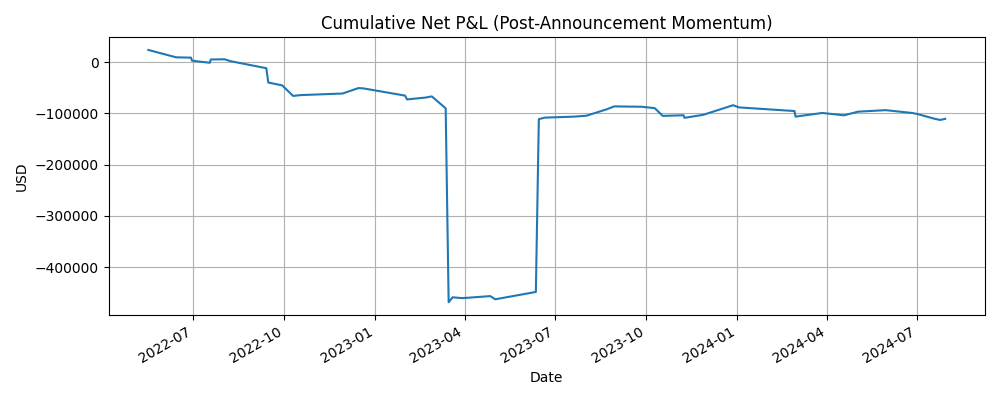

,announced,entry_date,exit_date,entry_open,exit_close,shares,gross_pnl,net_pnl,return,usd_invested,trade_days
count,100,100,100,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2023-05-06 20:24:00,2023-05-07 20:24:00,2023-05-12 01:12:00,53.792382,53.872051,7560.660000,-957.010885,-1108.224085,-0.002544,230260.197462,5.200000
min,2022-05-12 00:00:00,2022-05-13 00:00:00,2022-05-17 00:00:00,7.490000,7.460000,496.000000,-44042.655777,-44109.235777,-0.176455,12400.000000,0.000000
25%,2022-12-17 06:00:00,2022-12-18 06:00:00,2022-12-18 18:00:00,22.787500,23.100000,3322.500000,-7270.630437,-7614.695437,-0.037103,249912.652159,1.000000
50%,2023-06-05 00:00:00,2023-06-06 00:00:00,2023-06-12 00:00:00,35.480000,35.500000,6684.500000,244.327284,-159.368957,-0.000638,249981.126823,4.000000
75%,2023-08-28 00:00:00,2023-08-29 00:00:00,2023-08-30 00:00:00,68.137503,69.475002,9925.750000,7311.089108,7129.444108,0.033773,249991.273809,10.000000
max,2024-07-23 00:00:00,2024-07-24 00:00:00,2024-07-29 00:00:00,242.990005,247.669998,33377.000000,46976.758999,46845.538999,0.187402,249999.446926,10.000000
std,NaN,NaN,NaN,49.135748,50.054730,5940.126268,15755.837087,15761.401682,0.067747,47173.246224,3.905448


In [5]:
from IPython.display import Image, display
display(Image("../results/figures/post_announcement_momentum_pnl.png"))

bt_summary = bt.describe()
bt_summary

#### **Interpretation**
- **Total P&L:** Negative. Indicates the strategy, as implemented, was not profitable over the backtest window.
- **Win Rate:** 50%. The number of winning trades was equal to losers, but losers were larger.
- **Avg Holding Days:** Shows how long the position was typically held.
- **Graph:** The cumulative P&L line shows periods of gains/losses. The downward slope indicates persistent underperformance.

**4. Event Day Reversion**


This strategy bets against the day's overreaction, shorting outperformers and buying underperformers relative to the market on the trade date.


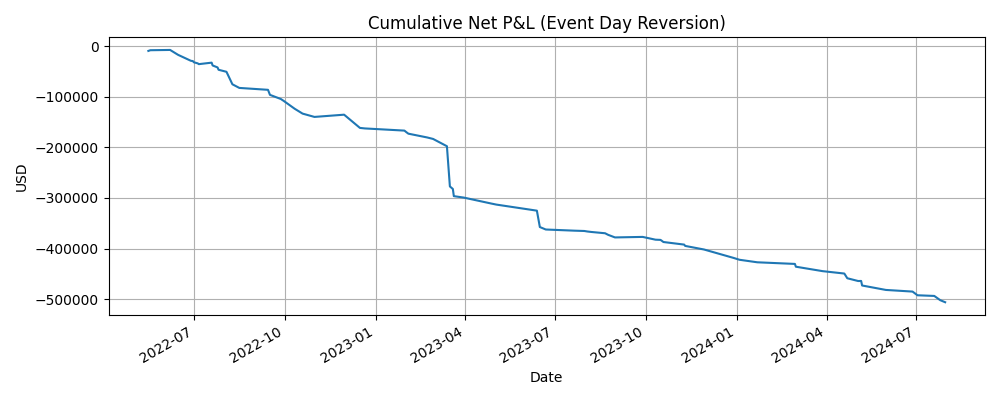

,event_date,direction,stk_open,stk_close,spy_open,spy_close,perf_delta,shares,gross_pnl,net_pnl,return,usd_invested
count,130,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,2023-04-27 03:52:36.923076864,-0.076923,58.388540,58.364622,425.509613,424.534458,0.001994,8167.492308,-3729.468440,-3892.818286,-0.019605,238767.967602
min,2022-05-16 00:00:00,-1.000000,7.400000,7.370000,358.239990,357.179993,-0.175875,153.000000,-16502.205723,-16652.225723,-0.236105,3220.649883
25%,2022-10-13 00:00:00,-1.000000,22.227500,22.347500,391.217491,389.989990,-0.014645,3374.500000,-6214.459924,-6413.987133,-0.027250,249949.416216
50%,2023-03-20 12:00:00,-1.000000,34.390001,34.555000,411.539993,413.400009,0.002815,6986.500000,-3119.353575,-3231.043575,-0.015379,249981.348831
75%,2023-08-29 06:00:00,1.000000,69.835001,69.632502,443.019989,439.459991,0.014505,10657.500000,-1016.696336,-1221.559633,-0.006666,249993.090534
max,2024-07-30 00:00:00,1.000000,415.000000,412.940002,552.419983,549.010010,0.247924,33783.000000,4643.940844,4428.589352,0.017719,250000.000000
std,NaN,1.000894,65.149537,65.075520,47.157211,47.374163,0.034595,6596.194501,3792.650019,3804.259988,0.028372,47660.345817


In [6]:
display(Image("../results/figures/event_day_reversion_pnl.png"))
rv.describe()

#### **Interpretation**
- **Total P&L:** Strongly negative, with low win rate.
- **Lesson:** The expected reversion effect may not exist, or costs are too high. It could also be the trade sizing or filtering.


**5. Buy-and-Hold (Announcement to Trade Date)**


This naive strategy simply buys at announcement and sells at the rebalance.


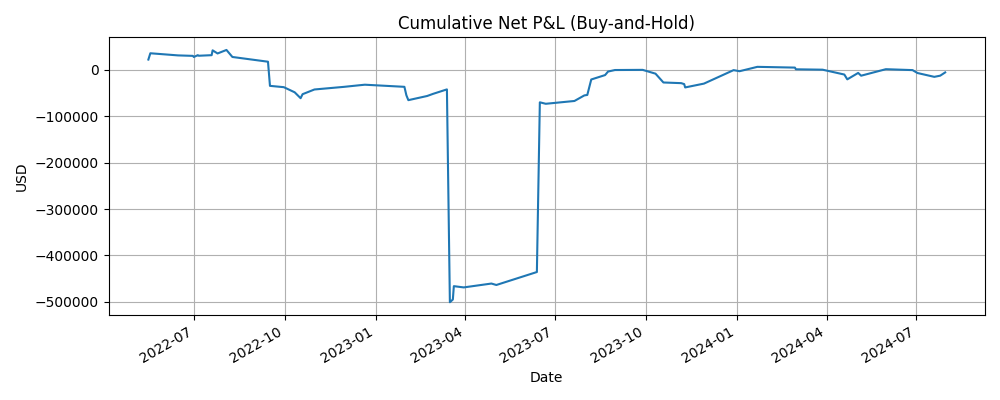

,entry_date,exit_date,entry_open,exit_close,shares,gross_pnl,net_pnl,return,usd_invested,trade_days
count,115,115,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,2023-05-05 06:28:10.434782720,2023-05-10 06:28:10.434782720,57.328158,57.760268,7367.052174,99.607882,-47.733161,0.000684,230008.957571,6.000000
min,2022-05-13 00:00:00,2022-05-16 00:00:00,7.490000,7.370000,96.000000,-52917.691466,-53173.951466,-0.212711,2208.000000,1.000000
25%,2022-11-13 00:00:00,2022-11-15 00:00:00,23.460000,23.780000,3042.000000,-7328.373909,-7471.373909,-0.033308,249912.147549,2.000000
50%,2023-06-06 00:00:00,2023-06-13 00:00:00,35.549999,35.060001,6598.000000,1075.227982,1046.167982,0.004186,249980.073479,5.000000
75%,2023-08-29 00:00:00,2023-08-31 00:00:00,72.060001,70.555000,9729.000000,9642.523111,9541.121554,0.042544,249990.462508,11.000000
max,2024-07-24 00:00:00,2024-07-30 00:00:00,242.990005,274.980011,33377.000000,51700.687008,51569.467008,0.206299,249999.446926,11.000000
std,NaN,NaN,53.053795,54.918643,6072.073776,17613.027444,17616.544522,0.076751,49611.752554,3.692097


In [7]:
display(Image("../results/figures/buy_and_hold_pnl.png"))
bh.describe()

#### **Interpretation**
- **Performance:** Essentially flat, with some winners but not enough to offset losers.
- **Implication:** Passive exposure to rebalance stocks does not consistently add value.

**6.Hedged Momentum (5-Day Hold)**

Long the rebalance stock, short SPY as a hedge, for 5 trading days.



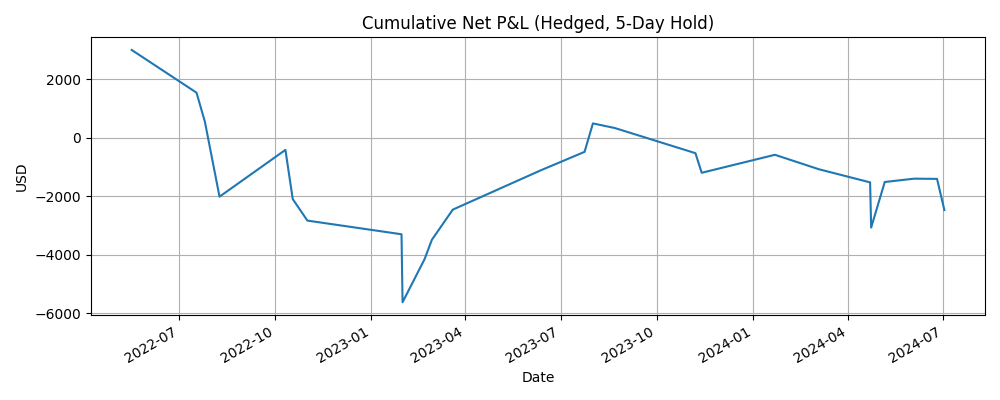

,entry_date,exit_date,entry_open,exit_close,shares,gross_pnl,spy_pnl,carry_cost,net_pnl,return,usd_invested,trade_days
count,34,34,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.0
mean,2023-04-25 23:17:38.823529472,2023-04-29 23:17:38.823529472,60.431740,60.287673,1120.470588,170.674760,-188.255524,32.790104,-72.780279,-0.007076,35201.140874,5.0
min,2022-05-13 00:00:00,2022-05-17 00:00:00,7.490000,7.370000,96.000000,-3513.844242,-1056.511444,2.056767,-3717.331060,-0.183635,2208.000000,5.0
25%,2022-10-07 00:00:00,2022-10-11 00:00:00,23.937500,23.882500,452.000000,-592.051348,-603.119385,33.710240,-669.143770,-0.022449,36188.934586,5.0
50%,2023-03-06 00:00:00,2023-03-10 00:00:00,36.865000,37.585001,896.500000,219.199165,-237.009247,33.730650,53.483368,0.001480,36210.845061,5.0
75%,2023-11-07 12:00:00,2023-11-11 12:00:00,72.895002,71.594999,1431.750000,1056.390075,-24.532356,33.738002,810.950281,0.022390,36218.737013,5.0
max,2024-06-28 00:00:00,2024-07-02 00:00:00,208.880005,208.940002,4837.000000,2938.248158,1100.541077,33.748867,1876.111956,0.051845,36230.401016,5.0
std,NaN,NaN,52.128795,52.021639,1050.876092,1383.240743,584.084410,5.430509,1219.735677,0.045886,5829.810673,0.0


In [8]:
display(Image("../results/figures/hedged_momentum_5d_pnl.png"))
hm.describe()

#### **Interpretation**
- **Sharpe Ratio/Drawdown:** (Discuss if calculated in your output)
- **Result:** This variant was still negative. Hedging with SPY did not save the strategy; the effect may be too weak or noise too high.


**7. Holding Period Sweep**

Explores P&L across a range of holding periods (1-10 days) after announcement.



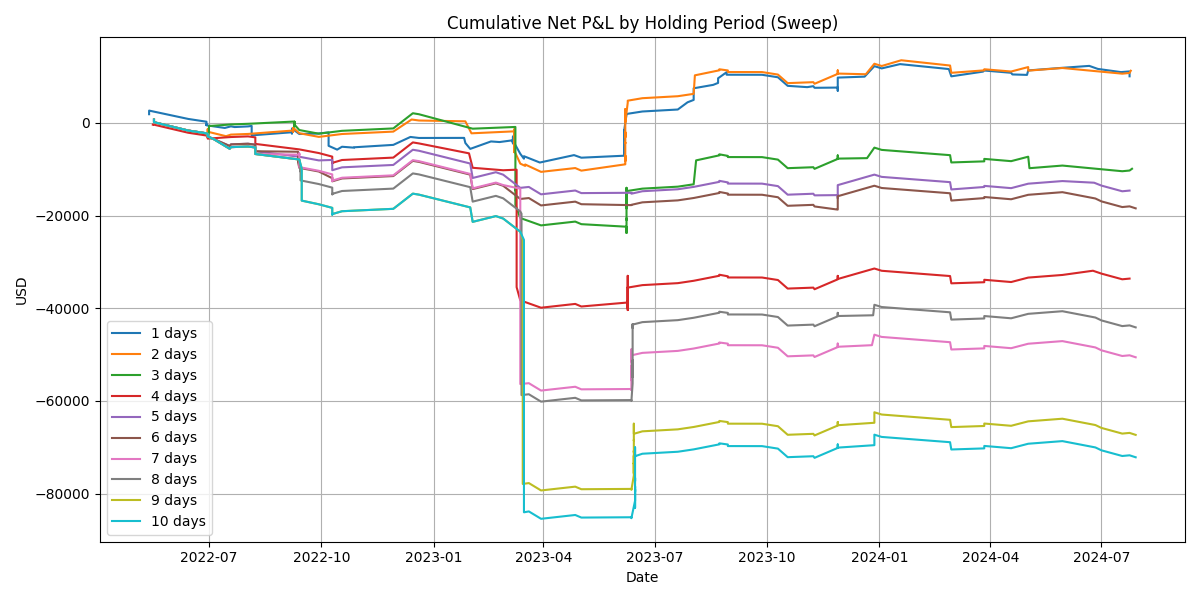

In [9]:
display(Image("../results/figures/sweep/holding_period_sweep_cum_pnl.png"))


#### **Interpretation**
- **Result:** None of the holding periods produced reliably positive results.
- **Visualization:** Each curve is a different holding period. All generally show no edge.

**8. Assignment Coverage & Conclusions**

- [x] Implemented at least three event-driven strategies (momentum, reversion, buy-and-hold, hedged)
- [x] Calculated and plotted cumulative P&L curves for each
- [x] Produced holding period sweep summary
- [x] Provided statistical summary of results
- [x] Interpreted and discussed the practical performance and lessons from each strategy

---

### Conclusions
- None of the strategies tested consistently generated positive returns in this dataset and time period.
- Both simple momentum and mean-reversion around index rebalancing events do not appear to produce reliable profits, at least at this trade size and with these costs.
- The strongest negative result is for event day reversion, suggesting that the mean-reversion effect (if any) is swamped by other factors.
- Even with hedging, returns do not turn positive, indicating these patterns are either already arbitraged away or not present in recent years.

### Next Steps & Suggestions
- Explore different windows (shorter/longer holds), additional filters, or alternate sizing rules.
- Consider transaction costs and slippage – these may significantly impact real-world returns.
- Investigate further with alternative event types, more granular data, or higher-frequency approaches.

---

